In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import make_column_selector as mcs
from sklearn.model_selection import cross_val_score


In [3]:
!pip install xgboost
!pip install optuna
import optuna
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
train_data=pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
test_data=pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

In [5]:
print(train_data.shape)
print(test_data.shape)

(100000, 76)
(10000, 75)


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

There are 100,000 rows and 76 columns in the train dataset & 10,000 rows and 75 columns in the test dataset

In [7]:
train_data.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [8]:
train_data.tail()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
99995,a378b2196a7a1d8ee0d4f989ee46730e,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1582.0,0,7.0,0,68585.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-21 00:59:00,2018-09-20,0
99996,7f4433ca05d24b9bbdd3932f8b05e61f,win8defender,1.1.15100.1,4.18.1806.18062,1.273.1156.0,0,7.0,0,11280.0,2.0,...,0,0.0,0,0,0.0,0.0,3.0,2018-08-10 07:23:00,2018-07-10,0
99997,d6852dfff534e03d5ddfd3c7875ab072,win8defender,1.1.15200.1,4.18.1807.18075,1.275.209.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,1.0,1.0,2018-08-26 23:51:00,2018-03-13,1
99998,70a8dc682128c9ff78a3de5aea9dac74,win8defender,1.1.14901.4,4.16.17656.18052,1.269.641.0,0,7.0,0,53447.0,1.0,...,1,0.0,1,1,1.0,0.0,1.0,2018-06-04 17:13:00,2018-05-08,0
99999,ad9c385b53f2ca788933a39603b84eda,win8defender,1.1.15000.2,4.18.1806.18062,1.271.1003.0,0,7.0,0,7945.0,2.0,...,1,0.0,0,0,0.0,1.0,11.0,2018-07-14 15:36:00,2018-08-14,0


# Exploratory Data Analysis

***Checking Null values***

In [9]:
pd.set_option("display.max_rows", None)
train_data.isnull().sum()

MachineID                               0
ProductName                             0
EngineVersion                           0
AppVersion                              0
SignatureVersion                        0
IsBetaUser                              0
RealTimeProtectionState                66
IsPassiveModeEnabled                    0
AntivirusConfigID                      76
NumAntivirusProductsInstalled          76
NumAntivirusProductsEnabled            76
HasTpm                                  0
CountryID                               0
CityID                                623
GeoRegionID                             0
LocaleEnglishNameID                     0
PlatformType                            0
Processor                               0
OSVersion                               0
OSBuildNumber                           0
OSProductSuite                          0
OsPlatformSubRelease                    0
OSBuildLab                              0
SKUEditionName                    

***These are the columns with no missing values, Hence they don't need any Imputation.***

In [10]:
no_missing_cols = train_data.columns[train_data.isnull().sum() == 0]
print("Columns with no missing values:")
print(no_missing_cols)
print("\nNumber of columns with no missing values:", len(no_missing_cols))

Columns with no missing values:
Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'IsPassiveModeEnabled', 'HasTpm',
       'CountryID', 'GeoRegionID', 'LocaleEnglishNameID', 'PlatformType',
       'Processor', 'OSVersion', 'OSBuildNumber', 'OSProductSuite',
       'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName',
       'AutoSampleSubmissionEnabled', 'MDC2FormFactor', 'DeviceFamily',
       'HasOpticalDiskDrive', 'PowerPlatformRole', 'NumericOSVersion',
       'OSArchitecture', 'OSBranch', 'OSBuildNumberOnly',
       'OSBuildRevisionOnly', 'OSEdition', 'OSSkuFriendlyName',
       'OSInstallType', 'OSUILocaleID', 'AutoUpdateOptionsName',
       'IsPortableOS', 'OSGenuineState', 'LicenseActivationChannel',
       'FlightRing', 'IsSecureBootEnabled', 'IsTouchEnabled', 'IsPenCapable',
       'DateAS', 'target'],
      dtype='object')

Number of columns with no missing values: 43


***43 columns have No missing values, That means 33 columns have missing values.***

***Checking No. of unique values in each feature.***

In [11]:
train_data.nunique()

MachineID                             99835
ProductName                               2
EngineVersion                            37
AppVersion                               69
SignatureVersion                       2735
IsBetaUser                                1
RealTimeProtectionState                   6
IsPassiveModeEnabled                      2
AntivirusConfigID                      1976
NumAntivirusProductsInstalled             5
NumAntivirusProductsEnabled               5
HasTpm                                    2
CountryID                               220
CityID                                16047
GeoRegionID                             239
LocaleEnglishNameID                     185
PlatformType                              4
Processor                                 3
OSVersion                                 7
OSBuildNumber                            24
OSProductSuite                            7
OsPlatformSubRelease                      9
OSBuildLab                      

In [12]:
one_unique_value = train_data.columns[train_data.nunique()==1]
print(one_unique_value)

Index(['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled'], dtype='object')


***These all have only one category So it will not help in our model. So we drop these columns***

In [13]:
unique_counts = train_data.nunique()

In [14]:
binary_cols = unique_counts[unique_counts == 2].index
binary_data = train_data[binary_cols]
print(binary_cols)
print("Total binary columns = ",len(binary_cols))

Index(['ProductName', 'IsPassiveModeEnabled', 'HasTpm', 'IsSystemProtected',
       'SMode', 'FirewallEnabled', 'DeviceFamily', 'HasOpticalDiskDrive',
       'IsPortableOS', 'IsSecureBootEnabled', 'IsVirtualDevice',
       'IsTouchEnabled', 'IsPenCapable', 'IsAlwaysOnAlwaysConnectedCapable',
       'IsGamer', 'target'],
      dtype='object')
Total binary columns =  16


In [15]:
binary_data = train_data[binary_cols]
print(binary_data.head())

    ProductName  IsPassiveModeEnabled  HasTpm  IsSystemProtected  SMode  \
0  win8defender                     0       1                1.0    0.0   
1  win8defender                     0       1                1.0    0.0   
2  win8defender                     0       1                1.0    0.0   
3  win8defender                     0       1                1.0    0.0   
4  win8defender                     0       1                1.0    0.0   

   FirewallEnabled     DeviceFamily  HasOpticalDiskDrive  IsPortableOS  \
0              1.0  Windows.Desktop                    0             0   
1              1.0  Windows.Desktop                    1             0   
2              1.0  Windows.Desktop                    1             0   
3              1.0  Windows.Desktop                    0             0   
4              1.0  Windows.Desktop                    0             0   

   IsSecureBootEnabled  IsVirtualDevice  IsTouchEnabled  IsPenCapable  \
0                    0         

***There are 16 columns which have have binary values. And as we can above the target column is also a binary column which tells us that this is a classification problem.***

In [16]:
train_data['target'].value_counts()/len(train_data)*100

target
1    50.525
0    49.475
Name: count, dtype: float64

***The dataset is  Fairly Balanced.***

# Visualization


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


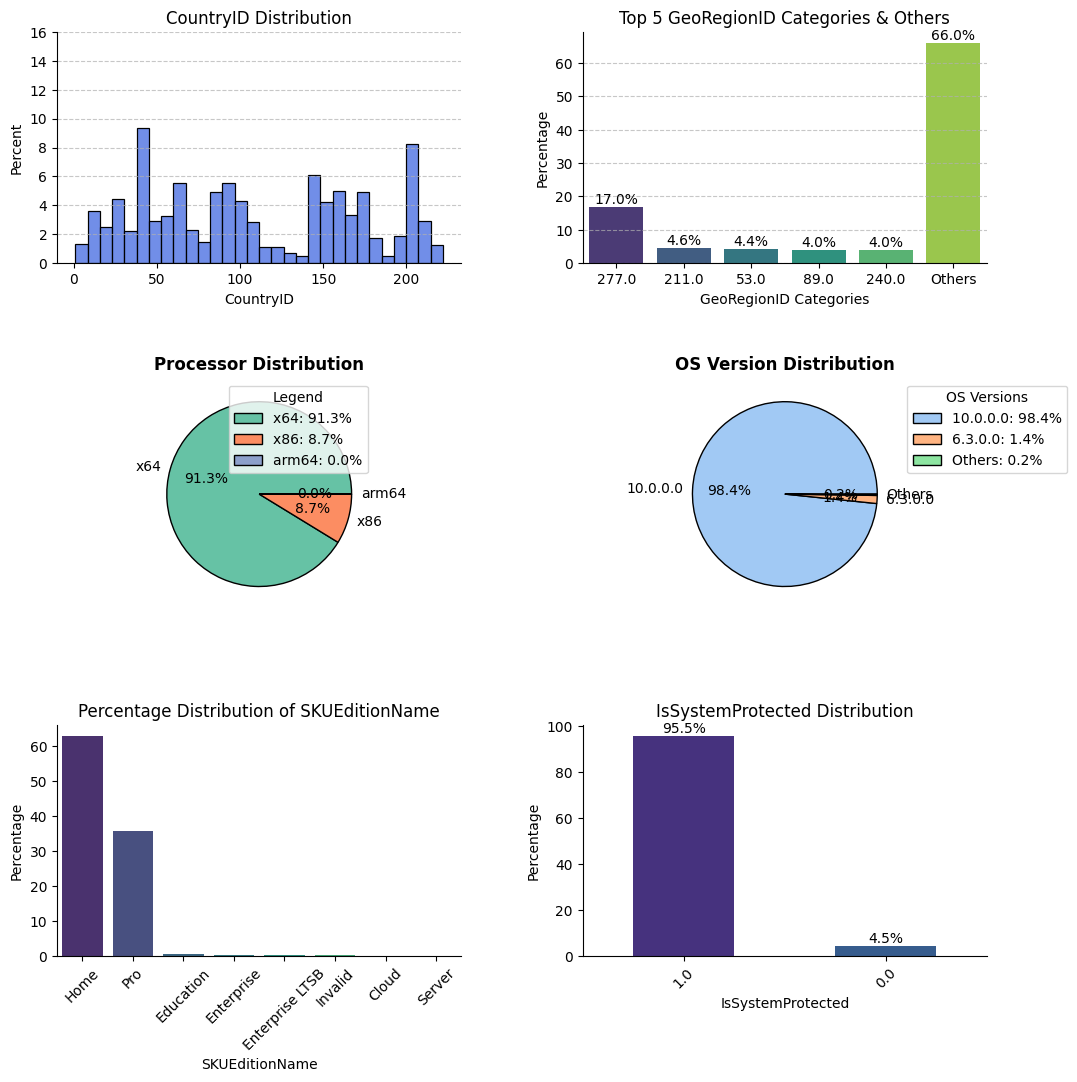

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# CountryID histogram
sns.histplot(train_data['CountryID'], stat="percent", bins=30, color="royalblue", ax=axes[0, 0])
axes[0, 0].set_ylim(0, 16)
axes[0, 0].set_yticks(range(0, 17, 2))
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].set_title("CountryID Distribution")
sns.despine()

# GeoRegionID bar plot
counts = train_data['GeoRegionID'].value_counts(normalize=True) * 100
final_counts = pd.concat([counts.iloc[:5], pd.Series({'Others': counts.iloc[5:].sum()})])
ax = sns.barplot(x=final_counts.index, y=final_counts.values, palette="viridis", ax=axes[0, 1])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=10)
axes[0, 1].set_xlabel("GeoRegionID Categories")
axes[0, 1].set_ylabel("Percentage")
axes[0, 1].set_title("Top 5 GeoRegionID Categories & Others")
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()

# Processor pie chart
counts = train_data['Processor'].value_counts(normalize=True) * 100
wedges, _, _ = axes[1, 0].pie(counts, labels=counts.index, autopct="%1.1f%%",
                              colors=sns.color_palette("Set2"), wedgeprops={'edgecolor': 'black'})
axes[1, 0].legend(wedges, [f"{i}: {v:.1f}%" for i, v in counts.items()], title="Legend", loc="upper right")
axes[1, 0].set_title("Processor Distribution", fontweight='bold')

# OSVersion pie chart
counts = train_data['OSVersion'].value_counts(normalize=True) * 100
final_counts = pd.concat([counts.iloc[:2], pd.Series({'Others': counts.iloc[2:].sum()})])
wedges, _, _ = axes[1, 1].pie(final_counts, labels=final_counts.index, autopct="%1.1f%%",
                              colors=sns.color_palette("pastel"), wedgeprops={'edgecolor': 'black'})
axes[1, 1].set_title("OS Version Distribution", fontweight='bold')
axes[1, 1].legend(wedges, [f'{label}: {percent:.1f}%' for label, percent in zip(final_counts.index, final_counts)],
                  title="OS Versions", loc="upper left", bbox_to_anchor=(1, 1))

# SKUEditionName bar chart
sku_counts = train_data['SKUEditionName'].value_counts(normalize=True) * 100
sns.barplot(x=sku_counts.index, y=sku_counts.values, palette="viridis", ax=axes[2, 0])
axes[2, 0].set_xlabel('SKUEditionName')
axes[2, 0].set_ylabel('Percentage')
axes[2, 0].set_title('Percentage Distribution of SKUEditionName')
axes[2, 0].tick_params(axis='x', rotation=45)

# IsSystemProtected bar chart
ax = (train_data['IsSystemProtected'].value_counts(normalize=True) * 100).plot(kind='bar', color=sns.color_palette("viridis"), ax=axes[2, 1])
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')
axes[2, 1].set_xlabel('IsSystemProtected')
axes[2, 1].set_ylabel('Percentage')
axes[2, 1].set_title('IsSystemProtected Distribution')
axes[2, 1].tick_params(axis='x', rotation=45)

plt.show()

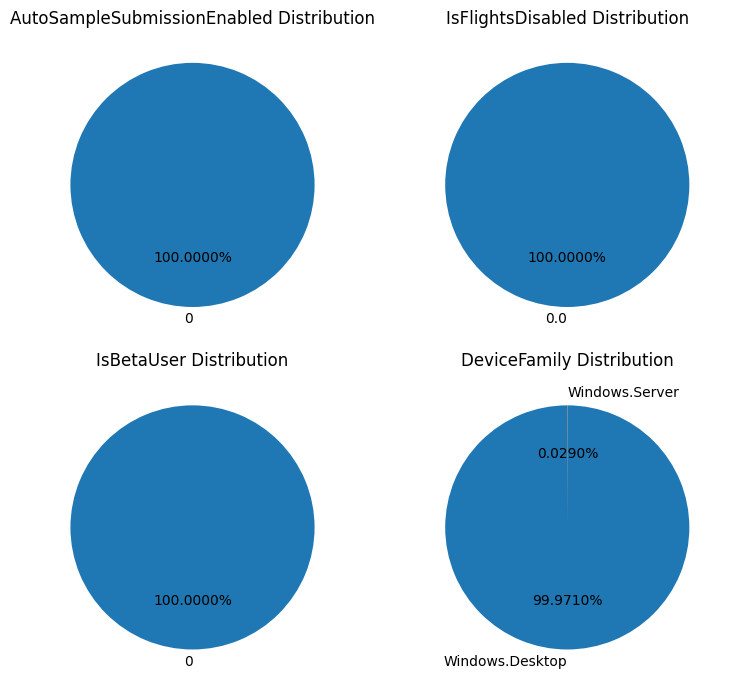

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7))

# AutoSampleSubmissionEnabled Pie Chart
counts = train_data['AutoSampleSubmissionEnabled'].value_counts(normalize=True) * 100
axes[0, 0].pie(counts, labels=counts.index, autopct='%1.4f%%', startangle=90)
axes[0, 0].set_title('AutoSampleSubmissionEnabled Distribution')

# IsFlightsDisabled Pie Chart
counts_flights = train_data['IsFlightsDisabled'].value_counts(normalize=True) * 100
axes[0, 1].pie(counts_flights, labels=counts_flights.index, autopct='%1.4f%%', startangle=90)
axes[0, 1].set_title('IsFlightsDisabled Distribution')

# IsBetaUser Pie Chart
counts_beta = train_data['IsBetaUser'].value_counts(normalize=True) * 100
axes[1, 0].pie(counts_beta, labels=counts_beta.index, autopct='%1.4f%%', startangle=90)
axes[1, 0].set_title('IsBetaUser Distribution')

# DeviceFamily Pie Chart
device_counts = train_data['DeviceFamily'].value_counts(normalize=True) * 100
axes[1, 1].pie(device_counts, labels=device_counts.index, autopct='%1.4f%%', startangle=90)
axes[1, 1].set_title('DeviceFamily Distribution')

plt.tight_layout()
plt.show()


As we saw in EDA the above charts have only one value, So we will drop these columns and in the last chart the Windows.Server is only 0.029% which is too less.

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


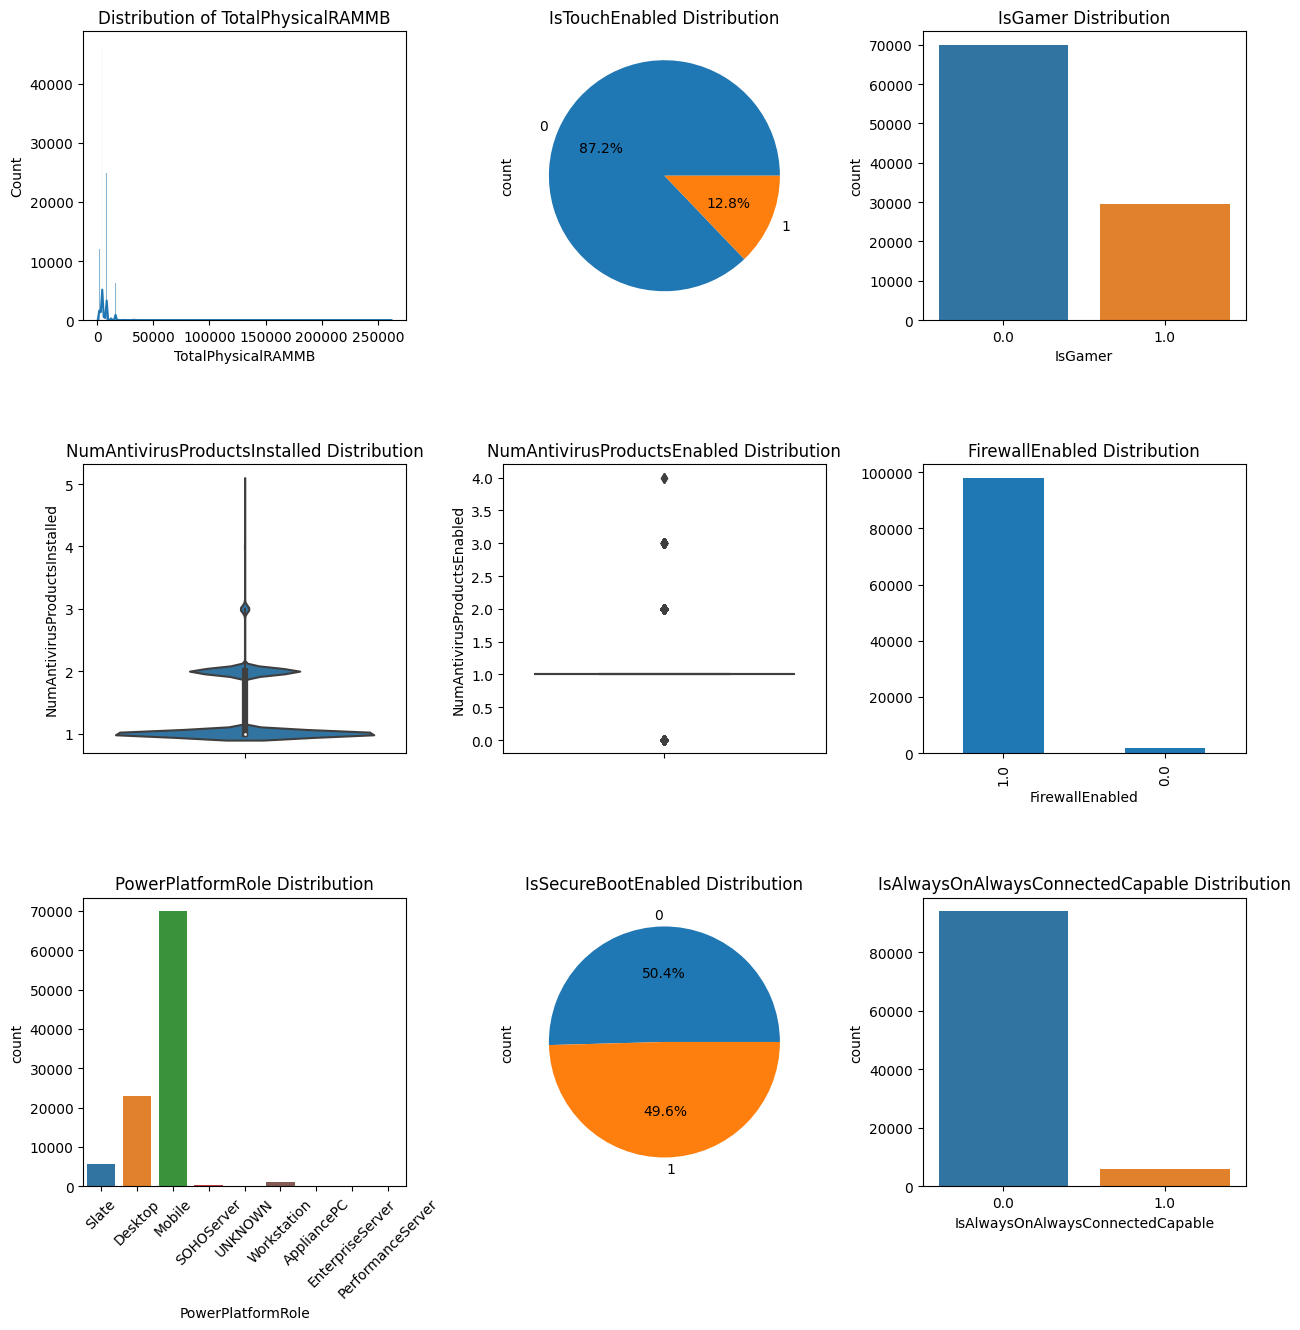

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# TotalPhysicalRAMMB
sns.histplot(train_data['TotalPhysicalRAMMB'], kde=True, ax=axes[0, 0])
axes[0,0].set_title('Distribution of TotalPhysicalRAMMB')

#IsTouchEnabled
train_data['IsTouchEnabled'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0,1])
axes[0,1].set_title('IsTouchEnabled Distribution')

#IsGamer
sns.countplot(x='IsGamer', data=train_data, ax=axes[0,2])
axes[0,2].set_title('IsGamer Distribution')


# NumAntivirusProductsInstalled
sns.violinplot(y='NumAntivirusProductsInstalled', data=train_data, ax=axes[1,0])
axes[1,0].set_title('NumAntivirusProductsInstalled Distribution')

#NumAntivirusProductsEnabled
sns.boxplot(y='NumAntivirusProductsEnabled', data=train_data, ax=axes[1,1])
axes[1,1].set_title('NumAntivirusProductsEnabled Distribution')

#FirewallEnabled
train_data['FirewallEnabled'].value_counts().plot(kind='bar', ax=axes[1,2])
axes[1,2].set_title("FirewallEnabled Distribution")

#PowerPlatformRole
sns.countplot(x='PowerPlatformRole', data=train_data, ax=axes[2,0])
axes[2,0].set_title('PowerPlatformRole Distribution')
axes[2,0].tick_params(axis='x', rotation=45)

#IsSecureBootEnabled
train_data['IsSecureBootEnabled'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[2,1])
axes[2,1].set_title('IsSecureBootEnabled Distribution')


#IsAlwaysOnAlwaysConnectedCapable
sns.countplot(x='IsAlwaysOnAlwaysConnectedCapable', data=train_data, ax=axes[2,2])
axes[2,2].set_title('IsAlwaysOnAlwaysConnectedCapable Distribution')

plt.show()


# Feature Engineering & Pre-Processing

Converting the categorical values into numerical values of ProductName and DeviceFamily columns

In [20]:
warnings.filterwarnings("ignore")
train_data['ProductName'] = train_data['ProductName'].replace({'win8defender': 1, 'mse': 0},)
train_data['DeviceFamily'] = train_data['DeviceFamily'].replace({'Windows.Server':0, 'Windows.Desktop':1},)

***Filling the blank values with 0***

In [21]:
columns_to_fill = [ 'NumAntivirusProductsEnabled', 'HasTpm', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID']
train_data[columns_to_fill] = train_data[columns_to_fill].fillna(0)

***Reducing the number of categories witin the column***

In [22]:
train_data['PrimaryDiskType'].unique()

array(['SSD', 'HDD', 'Unspecified', 'UNKNOWN', nan], dtype=object)

In [23]:
train_data['PrimaryDiskType'] = train_data['PrimaryDiskType'].replace(['UNKNOWN','Unknown','Unspecified'], 'UNKNOWN')
train_data['PrimaryDiskType'] = train_data['PrimaryDiskType'].fillna('UNKNOWN')

In the PrimaryDiskType the data is categorised in SSD, HDD, Unknown, Unspecified and UNKNOWN. So I have converted the unspecified and unknown into UNKNOWN which will redoce the categories to SSD, HDD and UNKNOWN.

In [24]:
train_data = train_data.drop(columns= ['IsBetaUser', 'AutoSampleSubmissionEnabled', 'IsFlightsDisabled','MachineID','CityID','OEMModelID','SystemVolumeCapacityMB','FirmwareVersionID','DeviceFamily'], errors='ignore')

In [25]:
numeric_cols = train_data.select_dtypes(include=['int']).columns.tolist()
object_cols = train_data.select_dtypes(include=['object']).columns.tolist()
float_cols = train_data.select_dtypes(include=['float64']).columns.tolist()

print("\nNumeric columns:", len(numeric_cols), numeric_cols)
print("\nObject columns:", len(object_cols), object_cols)
print("\nFloat columns:", len(float_cols), float_cols)


Numeric columns: 16 ['ProductName', 'IsPassiveModeEnabled', 'HasTpm', 'CountryID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'HasOpticalDiskDrive', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSUILocaleID', 'IsPortableOS', 'IsSecureBootEnabled', 'IsTouchEnabled', 'IsPenCapable', 'target']

Object columns: 25 ['EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']

Float columns: 26 ['RealTimeProtectionState', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'GeoRegionID', 'IsSystemProtected', 'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID', 'Proce

***Using Simple Imputer with mode stratergy to impute the data which is missing.***

In [26]:
train_data = train_data.replace({pd.NA: np.nan, '': np.nan, None: np.nan})
all_columns = {"numeric": numeric_cols, "object": object_cols, "float": float_cols}
mode_imputer = SimpleImputer(strategy='most_frequent')
for col_type, columns in all_columns.items():
    if columns:
        train_data[columns] = pd.DataFrame(
            mode_imputer.fit_transform(train_data[columns]),
            columns=columns,
            index=train_data.index
        )

***filling the null values and checking it***

Converting numeric into int :Ensures that all numeric values are stored as integers, removing unnecessary decimals.

Converting the object into string : Ensures categorical data is stored correctly as strings, preventing numeric conversions. Will be useful later when we use encoder 

In [27]:
for col in all_columns["numeric"]:
    train_data[col] = train_data[col].astype(int)
for col in all_columns["float"]:
    train_data[col] = train_data[col].astype(float)
for col in all_columns["object"]:
    train_data[col] = train_data[col].astype(str)


print(train_data.isnull().sum())

ProductName                           0
EngineVersion                         0
AppVersion                            0
SignatureVersion                      0
RealTimeProtectionState               0
IsPassiveModeEnabled                  0
AntivirusConfigID                     0
NumAntivirusProductsInstalled         0
NumAntivirusProductsEnabled           0
HasTpm                                0
CountryID                             0
GeoRegionID                           0
LocaleEnglishNameID                   0
PlatformType                          0
Processor                             0
OSVersion                             0
OSBuildNumber                         0
OSProductSuite                        0
OsPlatformSubRelease                  0
OSBuildLab                            0
SKUEditionName                        0
IsSystemProtected                     0
SMode                                 0
IEVersionID                           0
FirewallEnabled                       0


***Converting all the integers into float.***

In [28]:
int_cols = train_data.select_dtypes(include=['int64']).columns.tolist()
for col in int_cols:
    train_data[col] = train_data[col].astype('float64')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 67 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   ProductName                         100000 non-null  float64
 1   EngineVersion                       100000 non-null  object 
 2   AppVersion                          100000 non-null  object 
 3   SignatureVersion                    100000 non-null  object 
 4   RealTimeProtectionState             100000 non-null  float64
 5   IsPassiveModeEnabled                100000 non-null  float64
 6   AntivirusConfigID                   100000 non-null  float64
 7   NumAntivirusProductsInstalled       100000 non-null  float64
 8   NumAntivirusProductsEnabled         100000 non-null  float64
 9   HasTpm                              100000 non-null  float64
 10  CountryID                           100000 non-null  float64
 11  GeoRegionID                

Firstly there were 3 datatypes and after converting int into float there are only 2 which helps us manipulating the data. 
int64 cannot represent missing values (NaN), as NaN is a floating-point entity.
Some ML frameworks (like, XGBoost) may internally convert integers to floats, so doing it beforehand ensures consistency.


***Finding the correlation of each feature with the target feature.***

In [29]:
correlations = {}
float_cols = train_data.select_dtypes(include=['int64','float']).columns.tolist()

# Iterate through int64 columns and calculate the correlation with 'target'
for col in float_cols:
    if col != 'target':
        correlation = train_data[col].corr(train_data['target'])
        correlations[col] = abs(correlation)  # Take absolute value
sorted_correlations = dict(sorted(correlations.items(), key=lambda item: item[1], reverse=True))

for col, corr in sorted_correlations.items():
    print(f"Correlation between '{col}' and 'target': {corr}")

Correlation between 'NumAntivirusProductsInstalled' and 'target': 0.15112661954826917
Correlation between 'AntivirusConfigID' and 'target': 0.11814587405377452
Correlation between 'TotalPhysicalRAMMB' and 'target': 0.06568266537530583
Correlation between 'IsAlwaysOnAlwaysConnectedCapable' and 'target': 0.06474655260779519
Correlation between 'IsSystemProtected' and 'target': 0.0623180239006038
Correlation between 'IsGamer' and 'target': 0.06090142129232548
Correlation between 'ProcessorCoreCount' and 'target': 0.0565698885632745
Correlation between 'PrimaryDiskCapacityMB' and 'target': 0.04908678016770174
Correlation between 'RealTimeProtectionState' and 'target': 0.048976683993211687
Correlation between 'IsTouchEnabled' and 'target': 0.04614230100840552
Correlation between 'IsPassiveModeEnabled' and 'target': 0.04199661646513612
Correlation between 'IsVirtualDevice' and 'target': 0.039781886788428714
Correlation between 'NumAntivirusProductsEnabled' and 'target': 0.039138540502972906


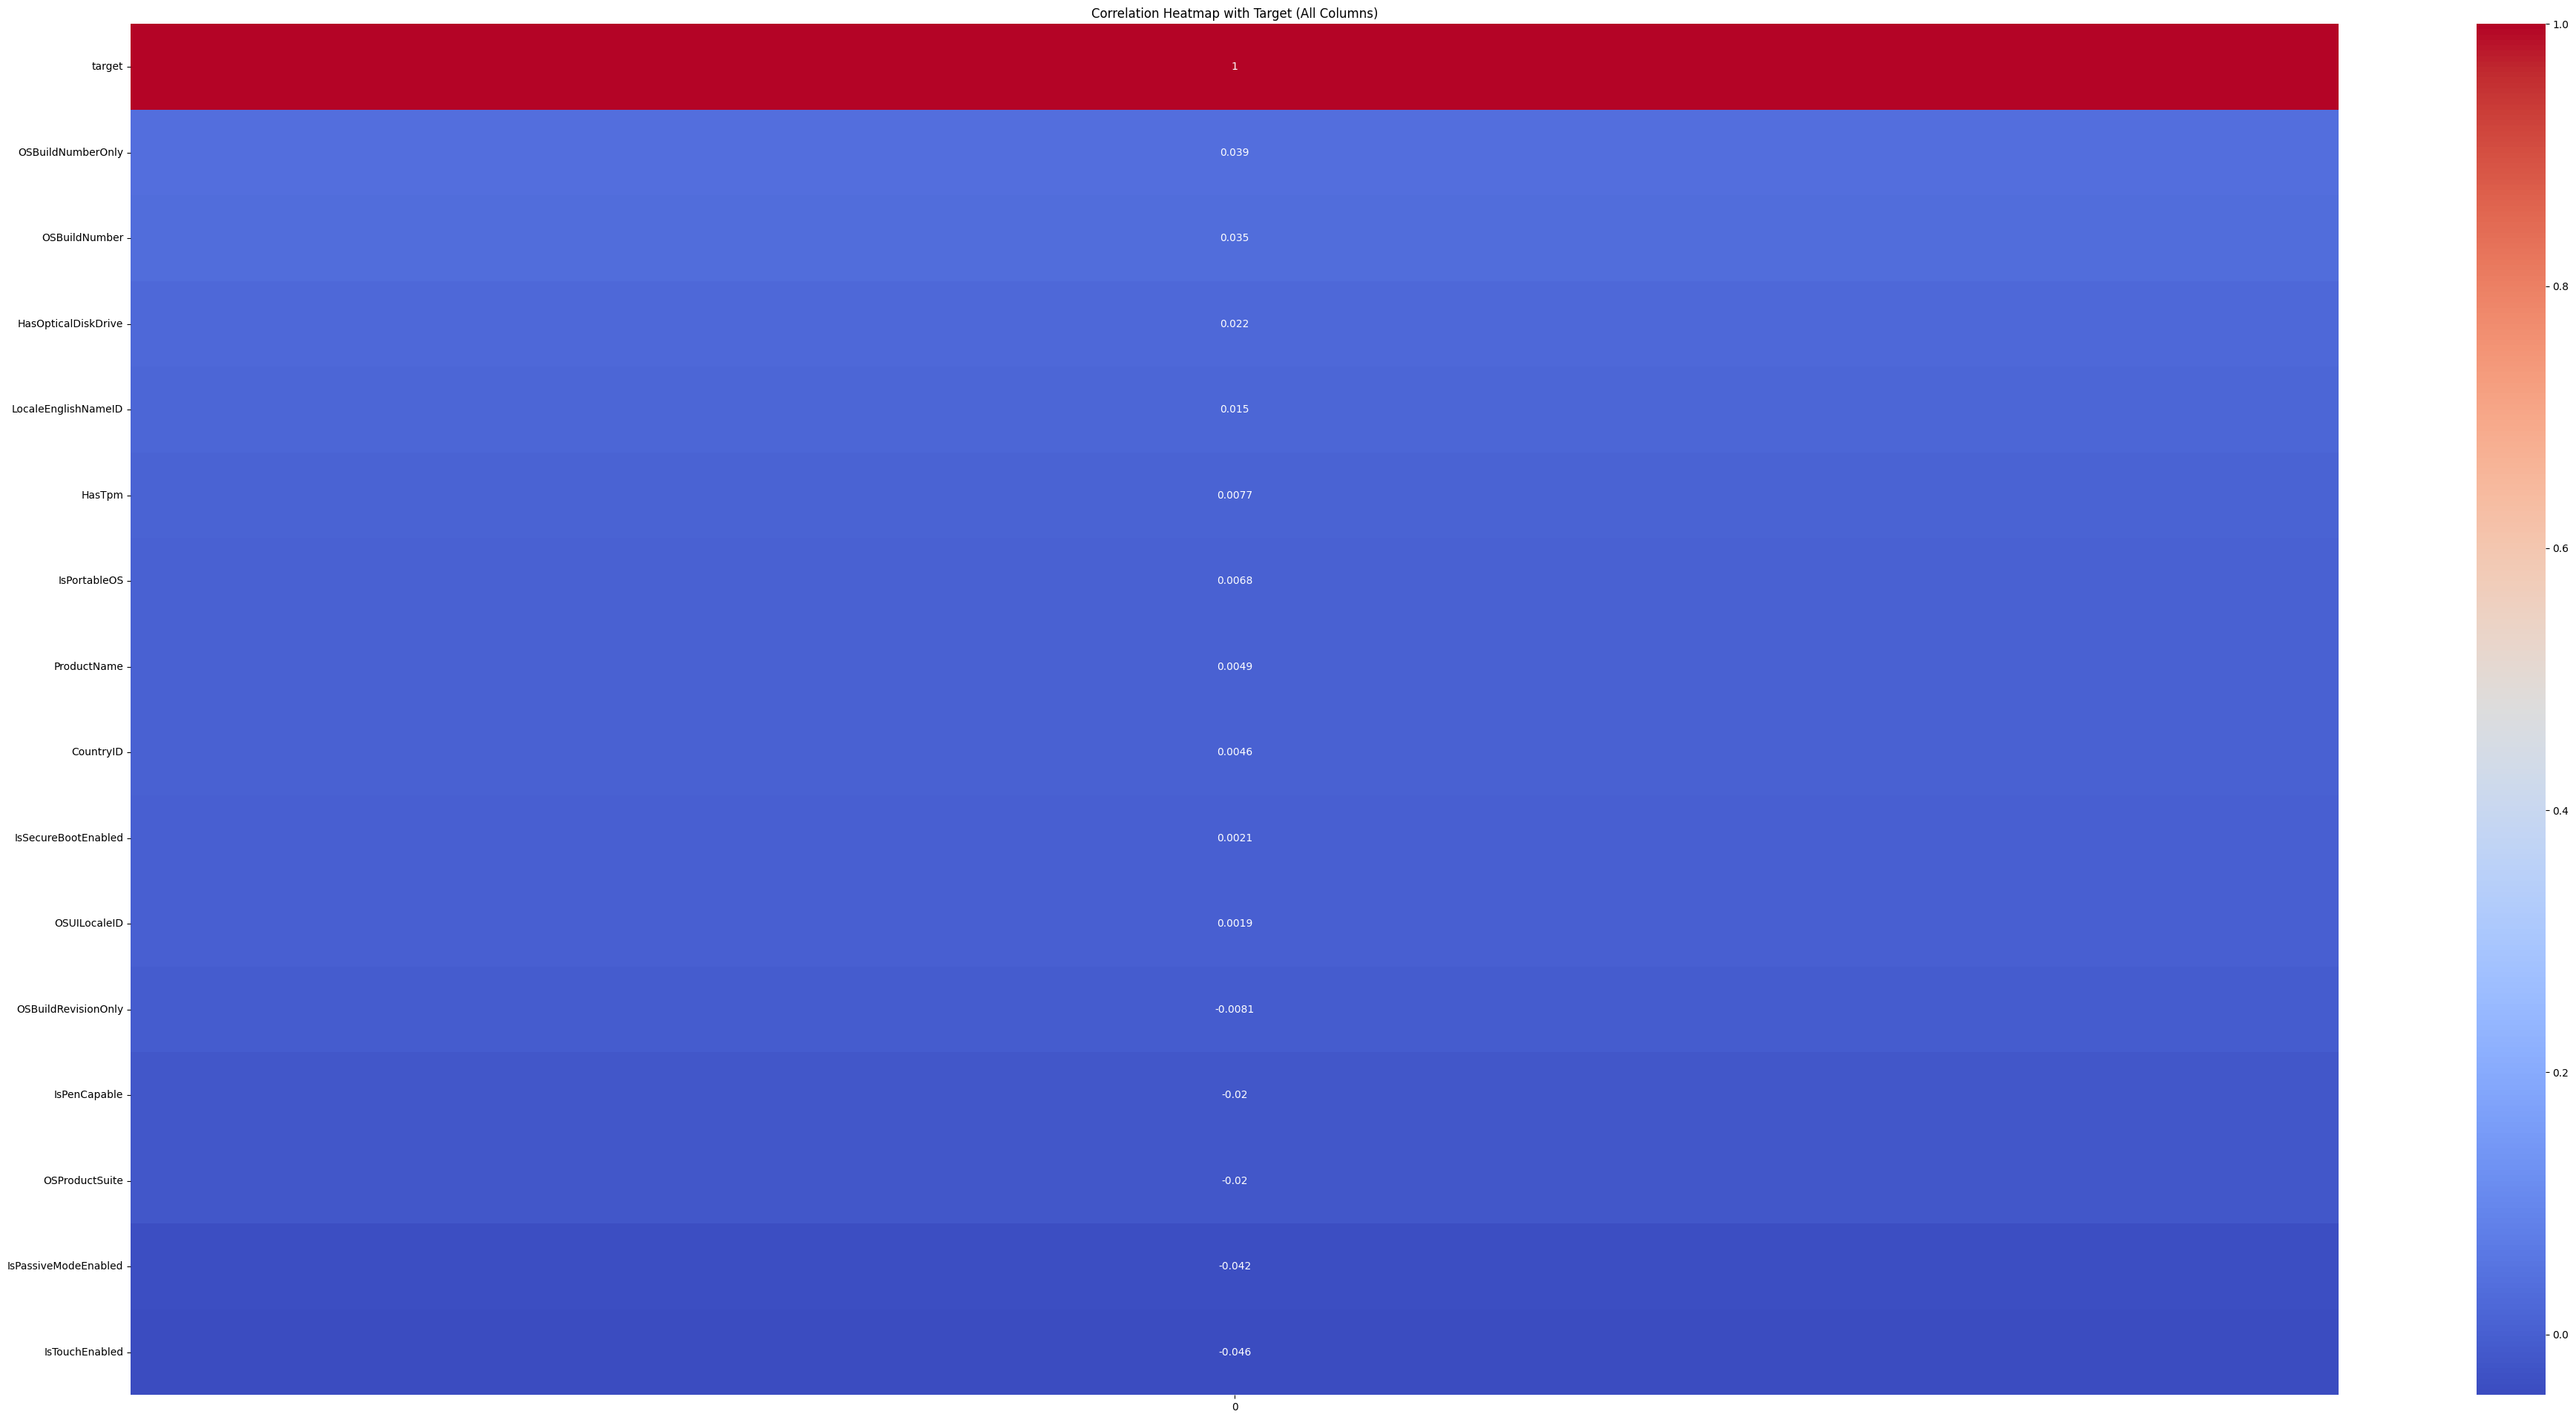

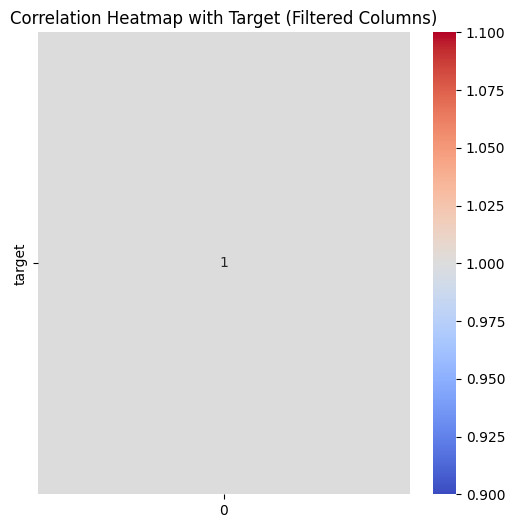

In [30]:
correlation_matrix = train_data[int_cols].corrwith(train_data['target'])

# Create the first heatmap
plt.figure(figsize=(48,24))
sns.heatmap(pd.DataFrame(correlation_matrix).sort_values(by=0, ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Target (All Columns)')
plt.show()

threshold = 0.1
filtered_columns = [col for col, corr in correlation_matrix.items() if abs(corr) >= threshold]

# Calculate the correlation matrix for filtered columns
filtered_correlation_matrix = train_data[filtered_columns].corrwith(train_data['target'])

# Create the second heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(pd.DataFrame(filtered_correlation_matrix).sort_values(by=0, ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Target (Filtered Columns)')
plt.show()

***This Heat map states the coorelation among the columns***

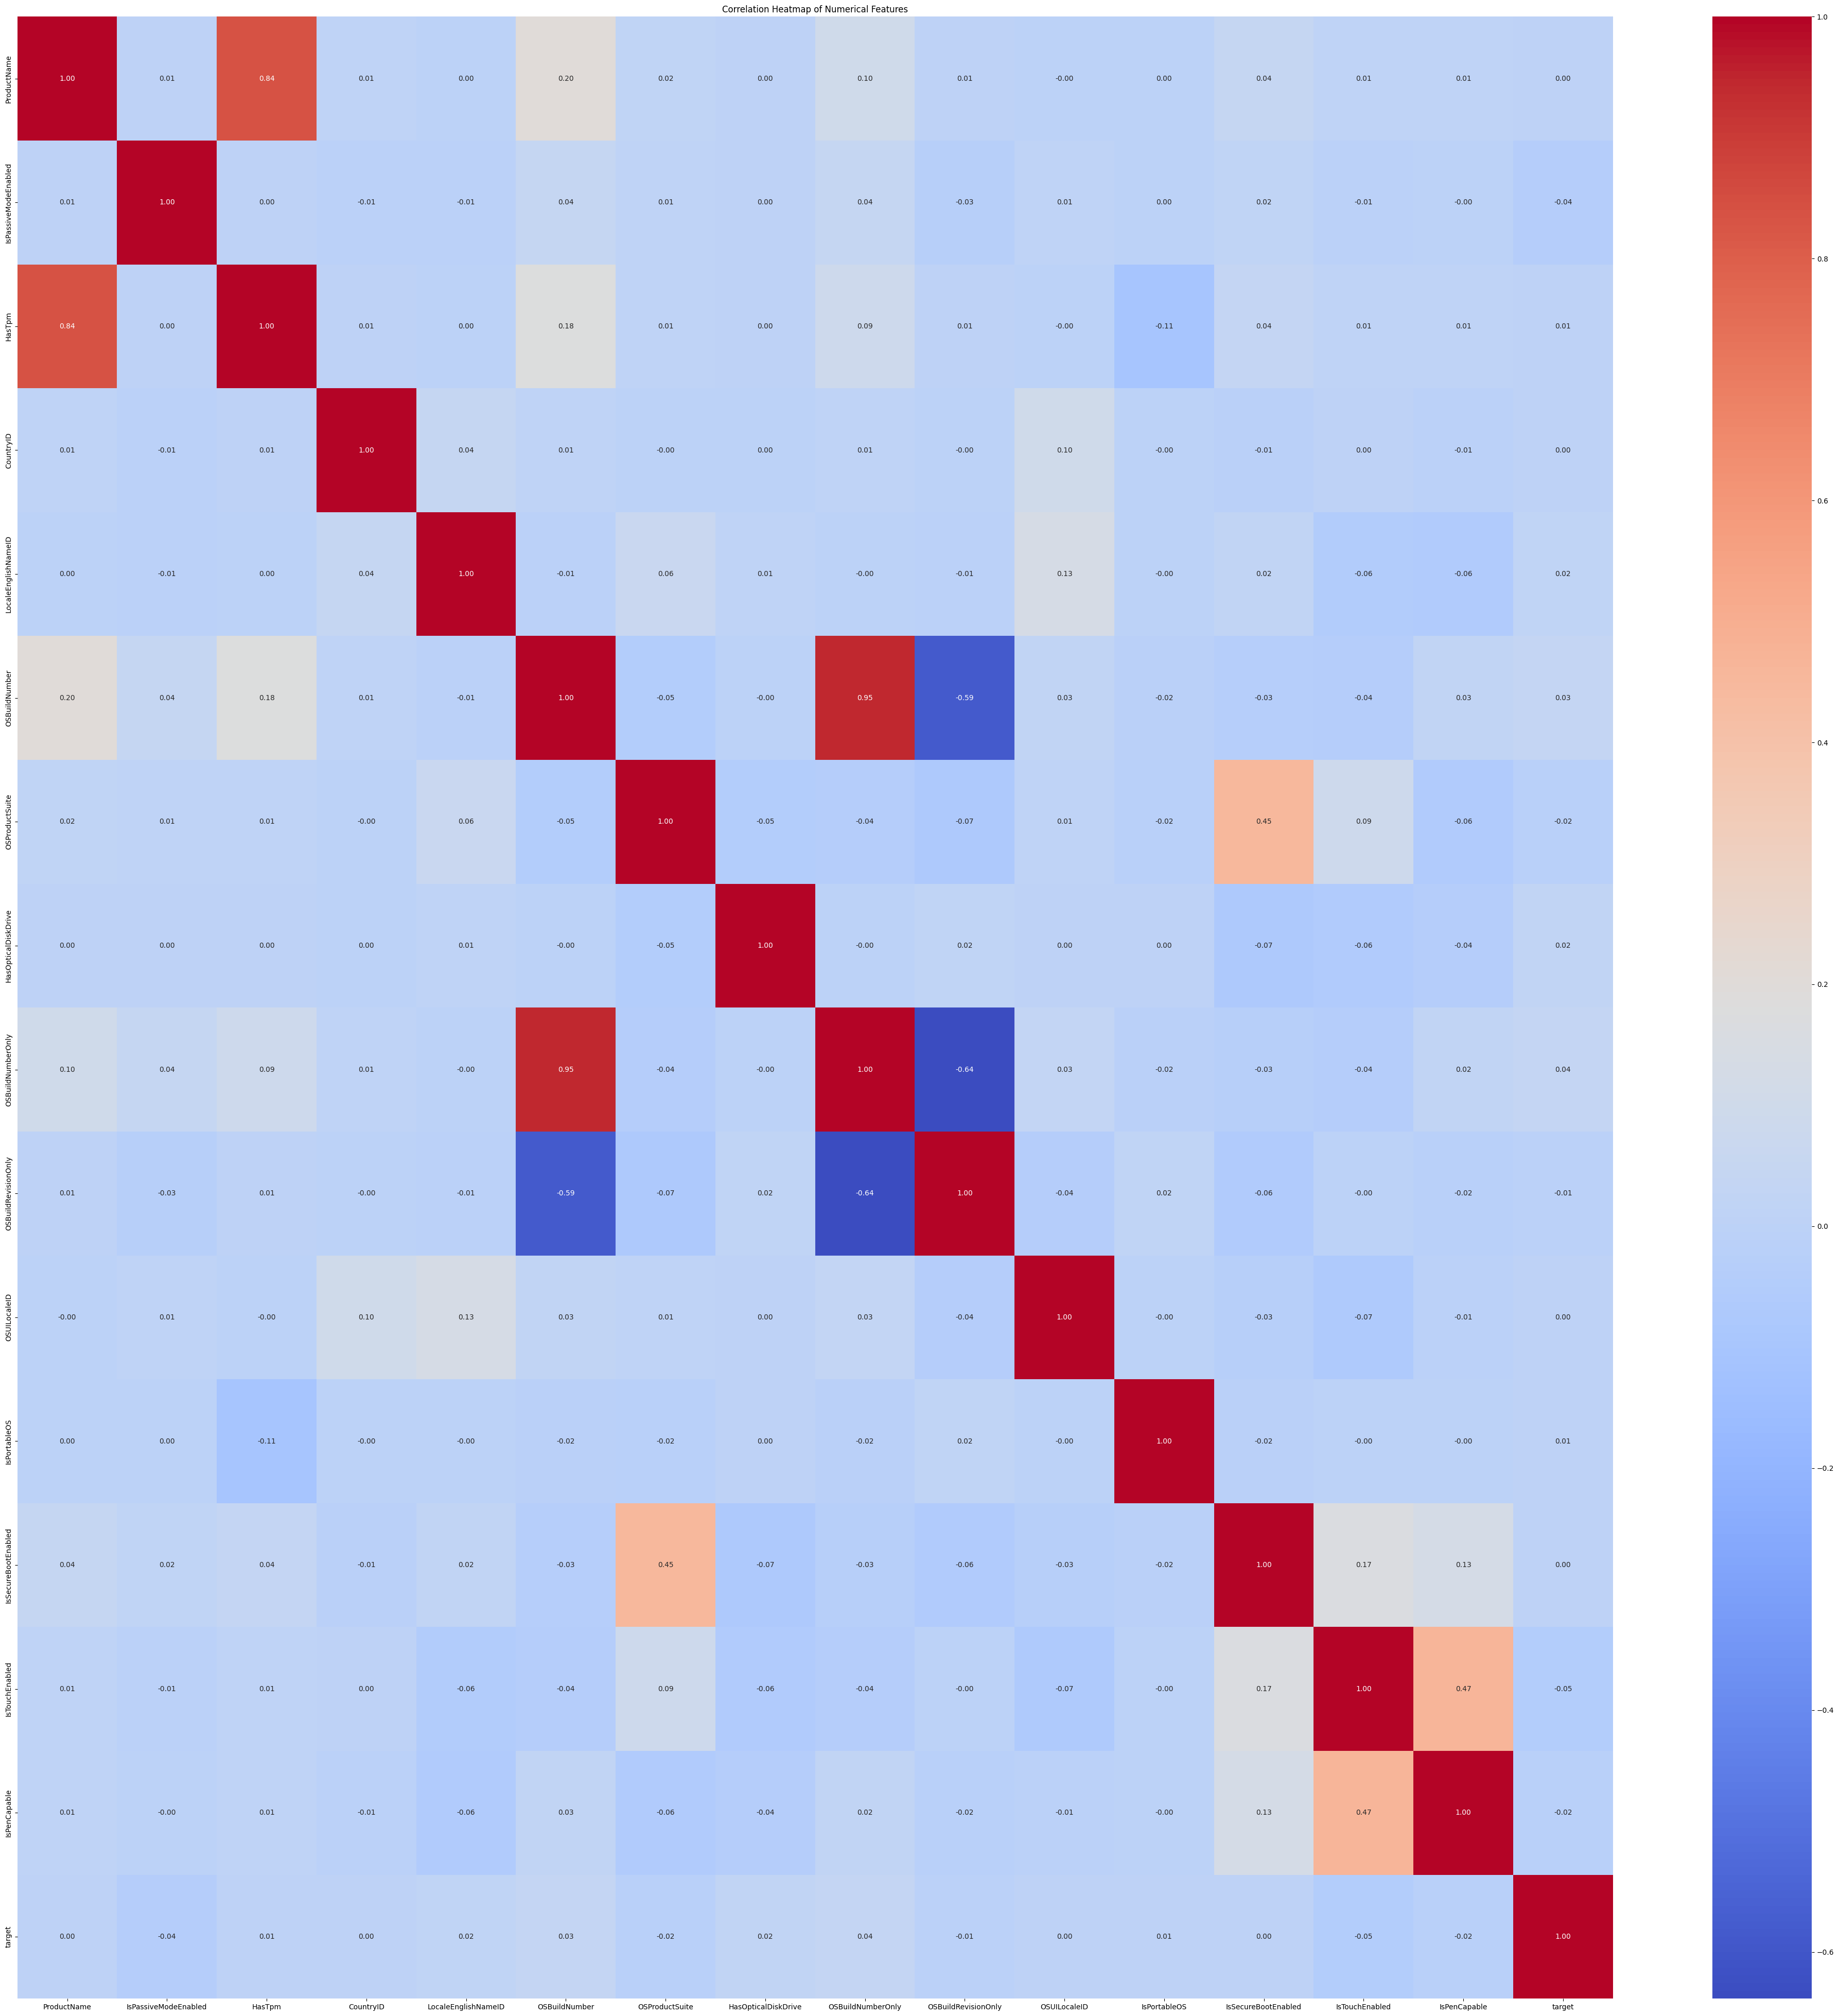

In [31]:
correlation_matrix = train_data[int_cols].corr()
# Create the heatmap
plt.figure(figsize=(50, 50))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [32]:
top_7_columns = list(sorted_correlations.keys())[:7]
top_7_columns

['NumAntivirusProductsInstalled',
 'AntivirusConfigID',
 'TotalPhysicalRAMMB',
 'IsAlwaysOnAlwaysConnectedCapable',
 'IsSystemProtected',
 'IsGamer',
 'ProcessorCoreCount']

In [33]:
unique_counts = train_data.nunique()

Correlation of Categorical Features

In [34]:
correlation_results = {}

# Iterate through object columns and calculate the relationship with 'target'
for col in object_cols:
    if col != 'target':
        # Group by the object column and calculate the mean of the target variable for each group
        relationship = train_data.groupby(col)['target'].mean()

        # Store the correlation results in the dictionary
        correlation_results[col] = relationship

# Sort all features by their correlation (standard deviation)
all_object_features = sorted(correlation_results.items(), key=lambda x: x[1].std(), reverse=True)

# Print all correlations
for feature, correlation in all_object_features:
    print(f"Feature: {feature}, Correlation: {correlation.std()}")

Feature: OSVersion, Correlation: 0.3762530804643262
Feature: SignatureVersion, Correlation: 0.3007191744051245
Feature: DateAS, Correlation: 0.30021787979218223
Feature: OSEdition, Correlation: 0.2672813542078498
Feature: OSBuildLab, Correlation: 0.26487522027811233
Feature: OSSkuFriendlyName, Correlation: 0.25284281580355317
Feature: PowerPlatformRole, Correlation: 0.21300393541687782
Feature: AppVersion, Correlation: 0.20947959651458817
Feature: NumericOSVersion, Correlation: 0.19302564451467788
Feature: ChassisType, Correlation: 0.18685748118627132
Feature: OSArchitecture, Correlation: 0.15915074665989765
Feature: Processor, Correlation: 0.15915029042516268
Feature: EngineVersion, Correlation: 0.1546545109270554
Feature: LicenseActivationChannel, Correlation: 0.1539970277622421
Feature: DateOS, Correlation: 0.1525608118843421
Feature: SKUEditionName, Correlation: 0.12831866129408556
Feature: MDC2FormFactor, Correlation: 0.12419513532657754
Feature: PlatformType, Correlation: 0.10940

***Object columns has more correlation compared to numeric columns. So we will select more Object columns.***

In [35]:
top_numeric_features = list(sorted_correlations.keys())[:7]
top_object_features = [feature for feature, correlation in all_object_features[:12]]

top_19_features = top_numeric_features + top_object_features
top_19_features


['NumAntivirusProductsInstalled',
 'AntivirusConfigID',
 'TotalPhysicalRAMMB',
 'IsAlwaysOnAlwaysConnectedCapable',
 'IsSystemProtected',
 'IsGamer',
 'ProcessorCoreCount',
 'OSVersion',
 'SignatureVersion',
 'DateAS',
 'OSEdition',
 'OSBuildLab',
 'OSSkuFriendlyName',
 'PowerPlatformRole',
 'AppVersion',
 'NumericOSVersion',
 'ChassisType',
 'OSArchitecture',
 'Processor']

In [36]:
top_object_features

['OSVersion',
 'SignatureVersion',
 'DateAS',
 'OSEdition',
 'OSBuildLab',
 'OSSkuFriendlyName',
 'PowerPlatformRole',
 'AppVersion',
 'NumericOSVersion',
 'ChassisType',
 'OSArchitecture',
 'Processor']

In [37]:
top_numeric_features

['NumAntivirusProductsInstalled',
 'AntivirusConfigID',
 'TotalPhysicalRAMMB',
 'IsAlwaysOnAlwaysConnectedCapable',
 'IsSystemProtected',
 'IsGamer',
 'ProcessorCoreCount']

***Combine the top selected object and numeric feature.***

In [38]:
top_numeric_features = ['NumAntivirusProductsInstalled','AntivirusConfigID','TotalPhysicalRAMMB','IsAlwaysOnAlwaysConnectedCapable','IsSystemProtected','IsGamer','ProcessorCoreCount','target']
top_object_features = ['OSVersion','DateAS','OSEdition','OSBuildLab','OSSkuFriendlyName','PowerPlatformRole','AppVersion','NumericOSVersion','ChassisType','OSArchitecture','Processor']

# Combine the numerical and categorical columns into a single list
selected_columns = top_numeric_features + top_object_features

# Select only the specified columns and drop all others
train_data = train_data[selected_columns]

# Verify the resulting DataFrame
print("Columns remaining in the DataFrame:", train_data.columns.tolist())
print(len(train_data.columns))

Columns remaining in the DataFrame: ['NumAntivirusProductsInstalled', 'AntivirusConfigID', 'TotalPhysicalRAMMB', 'IsAlwaysOnAlwaysConnectedCapable', 'IsSystemProtected', 'IsGamer', 'ProcessorCoreCount', 'target', 'OSVersion', 'DateAS', 'OSEdition', 'OSBuildLab', 'OSSkuFriendlyName', 'PowerPlatformRole', 'AppVersion', 'NumericOSVersion', 'ChassisType', 'OSArchitecture', 'Processor']
19


# Train-Test Split

---



In [39]:
y= train_data.target.copy()
x= train_data.drop('target', axis=1).copy()

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(x, y, test_size=0.2, random_state=1)

In [41]:
X_train.shape

(80000, 18)

#  Pipeline

In [42]:
from sklearn.compose import make_column_selector as mcs
num_sel = mcs(dtype_exclude='object')
cat_sel = mcs(dtype_include='object')

***numerical - Standard Scalar***

***Categorical - OrdinalEncoder***

In [43]:
# Creating numerical and categorical pipelines
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine numerical and categorical pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', num_pipeline, num_sel(X_train)),
    ('categorical', cat_pipeline, cat_sel(X_train))
])

# Create the final pipeline
pipe = Pipeline([('preprocessor', preprocessor)])

# Fit the pipeline
pipe.fit(X_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumAntivirusProductsInstalled',
                                                   'AntivirusConfigID',
                                                   'TotalPhysicalRAMMB',
                                                   'IsAlwaysOnAlwaysConnectedCapable',
                                                   'IsSystemProtected',
                                                   'IsGamer',
                                                   'ProcessorCoreCount']),
                                                 ('categorical',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['OSVersion', 'DateAS',
                                                   'OSEdition', 'OSBuildLab',
                                                   'OSSkuFriendlyName',
                                                   'PowerPlatformRole',
                                                   'AppVersion',
                                                   'NumericOSVersion',
                                                   'ChassisType',
                                                   'OSArchitecture',
                                                   'Processor'])]))])

In [44]:
X_train_trf = pipe.transform(X_train)
X_val_trf = pipe.transform(X_val)

In [45]:
X_train_trf.shape

(80000, 18)

# Selector : Recurssive Feature Extraction

***Feature Selection technique***

In [46]:
# Create and fit the RFE selector
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=18, step=1)
selector = selector.fit(X_train_trf, y_train)

# Get the selected features
selected_features = selector.support_

# Transform the data to include only selected features
X_train_selected = X_train_trf[:, selected_features]
X_val_selected = X_val_trf[:, selected_features]

# Print the selected feature indices
print("Selected feature indices:", np.where(selected_features)[0])

# If you want to get the names of the selected features (assuming you have feature names):
feature_names = pipe.get_feature_names_out()
selected_feature_names = feature_names[selected_features]
print("Selected feature names:", selected_feature_names)

Selected feature indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Selected feature names: ['numerical__NumAntivirusProductsInstalled' 'numerical__AntivirusConfigID'
 'numerical__TotalPhysicalRAMMB'
 'numerical__IsAlwaysOnAlwaysConnectedCapable'
 'numerical__IsSystemProtected' 'numerical__IsGamer'
 'numerical__ProcessorCoreCount' 'categorical__OSVersion'
 'categorical__DateAS' 'categorical__OSEdition' 'categorical__OSBuildLab'
 'categorical__OSSkuFriendlyName' 'categorical__PowerPlatformRole'
 'categorical__AppVersion' 'categorical__NumericOSVersion'
 'categorical__ChassisType' 'categorical__OSArchitecture'
 'categorical__Processor']


# Dummy Classsifier

In [47]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train_selected, y_train)

# Make predictions on validation set
y_pred = dc.predict(X_val_selected)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"DummyClassifier Accuracy: {accuracy:.4f}")

DummyClassifier Accuracy: 0.5016


In [ ]:
from sklearn.dataset import mnist 

Consider the MNIST dataset, split it into training and test set in 50:50 ratio with `random_state = 42`. Fit a SVM model using pipeline with StandardScalar, SVM classifier `kernel='poly'` and `degree = 3`,  `decision_function_shape='ovr'`and `class_weight='balanced'`, `C=10`. Train the model on training data, and make predictions for test data. Generate the Classification report and choose the correct value for weighted avg of f1_score.

# Model - SVM

In [48]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)
#kernel='linear' ->  Uses a linear kernel, meaning the decision boundary is a straight line
# C=1 ->  The regularization parameter 

# Train the classifier
svm_classifier.fit(X_train_selected,  y_train)

# Make predictions on the validation set
y_pred_svm = svm_classifier.predict(X_val_selected)

# Evaluate the model
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

print(classification_report(y_val, y_pred_svm))


SVM Accuracy: 0.5773
              precision    recall  f1-score   support

         0.0       0.61      0.42      0.50      9968
         1.0       0.56      0.73      0.64     10032

    accuracy                           0.58     20000
   macro avg       0.59      0.58      0.57     20000
weighted avg       0.59      0.58      0.57     20000



# Model - Random Forest Classifier

In [49]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_selected, y_train)

# Make predictions on validation set
y_pred = rf_classifier.predict(X_val_selected)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))


Random Forest Classifier Accuracy: 0.5749

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.59      0.58      9968
         1.0       0.58      0.56      0.57     10032

    accuracy                           0.57     20000
   macro avg       0.57      0.57      0.57     20000
weighted avg       0.57      0.57      0.57     20000



# Model - XGB

In [50]:
xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train_trf, y_train)
xgb_pred = xgb_clf.predict(X_val_trf)
xgb_accuracy = accuracy_score(y_val, xgb_pred)
print(f"XGB Classifier Accuracy: {xgb_accuracy}")
print(classification_report(y_val, xgb_pred))

XGB Classifier Accuracy: 0.61295
              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58      9968
         1.0       0.60      0.68      0.64     10032

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000



# Model - SGD classifier

In [51]:
# Create and train the SGD classifier
sgd_classifier = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, random_state=42)
sgd_classifier.fit(X_train_selected, y_train)

# Make predictions on the validation set
y_pred_sgd = sgd_classifier.predict(X_val_selected)

# Evaluate the model
accuracy_sgd = accuracy_score(y_val, y_pred_sgd)
print(f"SGD Classifier Accuracy: {accuracy_sgd:.4f}")

print(classification_report(y_val, y_pred_sgd))


SGD Classifier Accuracy: 0.5477
              precision    recall  f1-score   support

         0.0       0.70      0.16      0.26      9968
         1.0       0.53      0.93      0.67     10032

    accuracy                           0.55     20000
   macro avg       0.61      0.55      0.47     20000
weighted avg       0.61      0.55      0.47     20000



# Comparison of all the models 

Random Forest - 0.57 ; SVM - 0.57 ; XGB - 0.61 ; SGD - 0.47 .

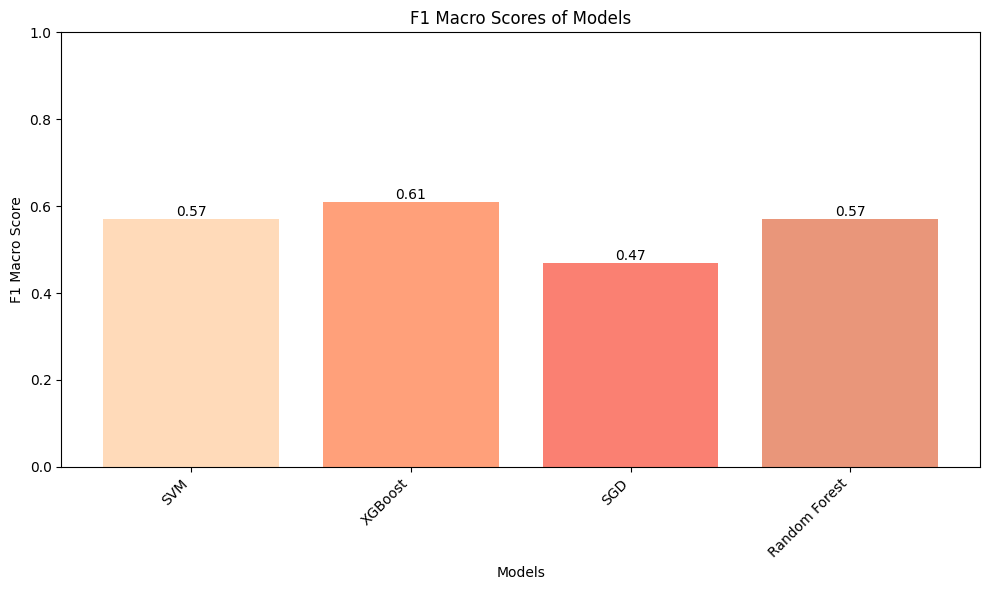

In [52]:
classification_reports = {
    'SVM': {'f1-score': 0.57},
    'XGBoost': {'f1-score': 0.61},
    'SGD': {'f1-score': 0.47},
    'Random Forest': {'f1-score': 0.57},
}
# Extract model names and f1-scores
models = list(classification_reports.keys())
f1_scores = [v['f1-score'] for v in classification_reports.values()]

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores, color=['#FFDAB9', '#FFA07A', '#FA8072', '#E9967A', '#F08080'])

# Add numbers on top of each bar
for bar, score in zip(bars, f1_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(score, 2), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('F1 Macro Score')
plt.title('F1 Macro Scores of Models')
plt.ylim(0, 1) # Set y-axis limit
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Hyperparameter Tuning

***Working on Test Data***

In [53]:
test_data['ProductName'] = test_data['ProductName'].replace({'win8defender': 1, 'mse': 0},)
test_data['DeviceFamily'] = test_data['DeviceFamily'].replace({'Windows.Server':0, 'Windows.Desktop':1},)
columns_to_fill = [ 'NumAntivirusProductsEnabled', 'HasTpm', 'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID']
test_data[columns_to_fill] = test_data[columns_to_fill].fillna(0)

In [54]:
numeric_cols = test_data.select_dtypes(include=['int']).columns.tolist()
object_cols = test_data.select_dtypes(include=['object']).columns.tolist()
float_cols = test_data.select_dtypes(include=['float64']).columns.tolist()

print("\nNumeric columns:", len(numeric_cols), numeric_cols)
print("\nObject columns:", len(object_cols), object_cols)
print("\nFloat columns:", len(float_cols), float_cols)


Numeric columns: 18 ['ProductName', 'IsBetaUser', 'IsPassiveModeEnabled', 'HasTpm', 'CountryID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite', 'AutoSampleSubmissionEnabled', 'DeviceFamily', 'HasOpticalDiskDrive', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSUILocaleID', 'IsPortableOS', 'IsSecureBootEnabled', 'IsTouchEnabled', 'IsPenCapable']

Object columns: 26 ['MachineID', 'EngineVersion', 'AppVersion', 'SignatureVersion', 'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease', 'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole', 'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition', 'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName', 'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS', 'DateOS']

Float columns: 31 ['RealTimeProtectionState', 'AntivirusConfigID', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 'CityID', 'GeoRegionID', 'IsSystemProtected', '

In [55]:
test_data = test_data.replace({pd.NA: np.nan, '': np.nan, None: np.nan})
all_columns = {"numeric": numeric_cols, "object": object_cols, "float": float_cols}
mode_imputer = SimpleImputer(strategy='most_frequent')
for col_type, columns in all_columns.items():
    if columns:  
        test_data[columns] = pd.DataFrame(
            mode_imputer.fit_transform(test_data[columns]),
            columns=columns,
            index=test_data.index
        )

In [56]:
for col in all_columns["numeric"]:
    test_data[col] = test_data[col].astype(int)
for col in all_columns["float"]:
    test_data[col] = test_data[col].astype(float)
for col in all_columns["object"]:
    test_data[col] = test_data[col].astype(str)


print(test_data.isnull().sum())

MachineID                             0
ProductName                           0
EngineVersion                         0
AppVersion                            0
SignatureVersion                      0
IsBetaUser                            0
RealTimeProtectionState               0
IsPassiveModeEnabled                  0
AntivirusConfigID                     0
NumAntivirusProductsInstalled         0
NumAntivirusProductsEnabled           0
HasTpm                                0
CountryID                             0
CityID                                0
GeoRegionID                           0
LocaleEnglishNameID                   0
PlatformType                          0
Processor                             0
OSVersion                             0
OSBuildNumber                         0
OSProductSuite                        0
OsPlatformSubRelease                  0
OSBuildLab                            0
SKUEditionName                        0
IsSystemProtected                     0


In [57]:
top_numeric_features = ['NumAntivirusProductsInstalled','AntivirusConfigID','TotalPhysicalRAMMB','IsAlwaysOnAlwaysConnectedCapable','IsSystemProtected','IsGamer','ProcessorCoreCount']
top_object_features = ['OSVersion','SignatureVersion','DateAS','OSEdition','OSBuildLab','OSSkuFriendlyName','PowerPlatformRole','AppVersion','NumericOSVersion','ChassisType','OSArchitecture','Processor']
# Combine the numerical and categorical columns into a single list
selected_columns = top_numeric_features + top_object_features

# Select only the specified columns and drop all others
test_data = test_data[selected_columns]

# Verify the resulting DataFrame
print("Columns remaining in the DataFrame:", test_data.columns.tolist())
print(len(test_data.columns))

Columns remaining in the DataFrame: ['NumAntivirusProductsInstalled', 'AntivirusConfigID', 'TotalPhysicalRAMMB', 'IsAlwaysOnAlwaysConnectedCapable', 'IsSystemProtected', 'IsGamer', 'ProcessorCoreCount', 'OSVersion', 'SignatureVersion', 'DateAS', 'OSEdition', 'OSBuildLab', 'OSSkuFriendlyName', 'PowerPlatformRole', 'AppVersion', 'NumericOSVersion', 'ChassisType', 'OSArchitecture', 'Processor']
19


# Tuning Random Forest

In [58]:
#RFE Feature Selection
estimator = LogisticRegression(max_iter=10000)
selector = RFE(estimator, n_features_to_select=18, step=1)
selector = selector.fit(X_train_trf, y_train)

selected_features = selector.support_

# Transform the data to include only selected features
X_train_selected = X_train_trf[:, selected_features]
X_val_selected = X_val_trf[:, selected_features]

feature_names = pipe.get_feature_names_out()
selected_feature_names = feature_names[selected_features]
print("Selected feature names:", selected_feature_names)

# Define Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }

    rf_model = RandomForestClassifier(**params, random_state=42)
    return cross_val_score(rf_model, X_train_selected, y_train, cv=3, scoring='accuracy').mean()

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

best_params = study.best_params
print("Best parameters:", best_params)

# Train final model with best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train_selected, y_train)

# Evaluate on validation set
y_val_pred = best_model.predict(X_val_selected)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Tuned Random Forest Classifier Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


[I 2025-03-02 11:44:04,336] A new study created in memory with name: no-name-14b5ff70-dfde-4960-8ee8-a810bbef0b3d


Selected feature names: ['numerical__NumAntivirusProductsInstalled' 'numerical__AntivirusConfigID'
 'numerical__TotalPhysicalRAMMB'
 'numerical__IsAlwaysOnAlwaysConnectedCapable'
 'numerical__IsSystemProtected' 'numerical__IsGamer'
 'numerical__ProcessorCoreCount' 'categorical__OSVersion'
 'categorical__DateAS' 'categorical__OSEdition' 'categorical__OSBuildLab'
 'categorical__OSSkuFriendlyName' 'categorical__PowerPlatformRole'
 'categorical__AppVersion' 'categorical__NumericOSVersion'
 'categorical__ChassisType' 'categorical__OSArchitecture'
 'categorical__Processor']


[I 2025-03-02 11:45:00,755] Trial 0 finished with value: 0.6078625153463989 and parameters: {'n_estimators': 921, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6078625153463989.
[I 2025-03-02 11:45:56,767] Trial 1 finished with value: 0.6158125256615122 and parameters: {'n_estimators': 462, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 11}. Best is trial 1 with value: 0.6158125256615122.
[I 2025-03-02 11:48:01,404] Trial 2 finished with value: 0.6140125209733911 and parameters: {'n_estimators': 945, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.6158125256615122.
[I 2025-03-02 11:49:15,138] Trial 3 finished with value: 0.6107125200348481 and parameters: {'n_estimators': 496, 'max_depth': 31, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.6158125256615122.
[I 2025-03-02 11:50:14,347] Trial 4 finished with value: 0.6118375214414672 and parameters

Best parameters: {'n_estimators': 462, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 11}
Tuned Random Forest Classifier Accuracy: 0.6148

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.55      0.59      9968
         1.0       0.60      0.68      0.64     10032

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000



# Tuning XGB 

In [59]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    # Train the XGBoost model
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **params)
    model.fit(X_train_trf, y_train)

    # Predict and evaluate accuracy on validation set
    y_pred = model.predict(X_val_trf)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the best model on the full training data
best_params = study.best_params
best_model_XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params)
best_model_XGB.fit(X_train_trf, y_train)

# Evaluate on the validation set
y_pred = best_model_XGB.predict(X_val_trf)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")
print(classification_report(y_val, xgb_pred))

[I 2025-03-02 11:50:41,412] A new study created in memory with name: no-name-ecfa9005-a8eb-4d33-8a85-f4c9f07b533a
[I 2025-03-02 11:50:42,356] Trial 0 finished with value: 0.6121 and parameters: {'learning_rate': 0.018483794705473663, 'max_depth': 7, 'n_estimators': 186, 'subsample': 0.7397103170846517, 'colsample_bytree': 0.8161096280030877}. Best is trial 0 with value: 0.6121.
[I 2025-03-02 11:50:43,278] Trial 1 finished with value: 0.61075 and parameters: {'learning_rate': 0.012054260654211868, 'max_depth': 7, 'n_estimators': 193, 'subsample': 0.9168412632207281, 'colsample_bytree': 0.5114599459652664}. Best is trial 0 with value: 0.6121.
[I 2025-03-02 11:50:43,879] Trial 2 finished with value: 0.6098 and parameters: {'learning_rate': 0.02617620635865986, 'max_depth': 4, 'n_estimators': 191, 'subsample': 0.8540319986297502, 'colsample_bytree': 0.8726276555627219}. Best is trial 0 with value: 0.6121.
[I 2025-03-02 11:50:44,476] Trial 3 finished with value: 0.6141 and parameters: {'lea

Best Hyperparameters: {'learning_rate': 0.11531697309068899, 'max_depth': 8, 'n_estimators': 84, 'subsample': 0.6227201127698949, 'colsample_bytree': 0.9868875040376872}
Validation Accuracy: 0.61535
              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58      9968
         1.0       0.60      0.68      0.64     10032

    accuracy                           0.61     20000
   macro avg       0.62      0.61      0.61     20000
weighted avg       0.62      0.61      0.61     20000



In [60]:
test_transform = pipe.transform(test_data)

y_test_pred = best_model_XGB.predict(test_transform)

In [61]:
prediction_df = pd.DataFrame({
    'id': test_data.index,   # Ensure you have an 'id' column or relevant index
    'target': y_test_pred       # Replace with y_pred_mapped if label mapping is applied
})

In [62]:
prediction_df.to_csv('/kaggle/working/submission.csv', index=False)